In [ ]:
import os
import re
import json
import logging
import neo4j
import pyvis
import time

In [ ]:
USERNAME = ''
PASSWORD = ''

DB = ''
URI = ''
AUTH = (USERNAME, PASSWORD)

In [ ]:
# with neo4j.GraphDatabase.driver(URI, auth=AUTH, database=DB) as driver:
#     driver.verify_connectivity()

#     records, summary, keys = driver.execute_query('MATCH (n) RETURN n AS node')
#     # result = driver.execute_query('MATCH (n) RETURN n AS node', result_transformer_=neo4j.Result.graph)
    
#     summary_text = "The query `{query}` returned {records_count} {keys} records in {time} ms".format(
#         query=summary.query,
#         keys=keys,
#         records_count=len(records),
#         time=summary.result_available_after
#     )

#     print(summary_text)
#     print('=' * len(summary_text))

#     for record in records:
#         print(record.data())

In [ ]:
# CREATE_REGULATION_NODE = '''
# MERGE (r:Regulation {id: $id})
# SET r.name = $name, 
#     r.title = $title,
#     r.about = $about,
#     r.type = $type,
#     r.amendment = $amendment,
#     r.number = $number,
#     r.year = $year,
#     r.institution = $institution,
#     r.issue_place = $issue_place,
#     r.issue_date = $issue_date,
#     r.effective_date = $effective_date,
#     r.subjects = $subjects,
#     r.url = $url
# WITH r
# CALL apoc.create.addLabels(r, $labels)
# YIELD node
# RETURN node
# '''

# CREATE_REGULATION_RELATIONSHIP = '''
# MATCH (source:Regulation {id: $source_id})
# MATCH (target:Regulation {id: $target_id})
# MERGE (source)-[rel:AMENDED_BY {number: target.amendment}]->(target)
# RETURN rel
# ''' 

# CREATE_SIMPLE_NODE_1 = '''
# MERGE (n {id: $id})
# SET n.text = $text
# WITH n
# CALL apoc.create.addLabels(n, $labels)
# YIELD node
# MATCH (regulation {id: $regulation_id})
# CALL apoc.create.relationship(regulation, $relationship_type, {}, node)
# YIELD rel
# RETURN rel
# '''

# CREATE_SIMPLE_NODE_2 = '''
# MERGE (n {id: $id})
# SET n.name = $name,
#     n.definition = $definition
# WITH n
# CALL apoc.create.addLabels(n, $labels)
# YIELD node
# MATCH (regulation {id: $regulation_id})
# CALL apoc.create.relationship(regulation, $relationship_type, {}, node)
# YIELD rel
# RETURN rel
# '''

In [ ]:
DIR_PATH = 'data'
json_input = os.path.join(DIR_PATH, 'regulation_data_final.json')

# https://stackoverflow.com/questions/20199126/reading-json-from-a-file
with open(json_input) as file:
    json_data = json.load(file)

In [ ]:
def create_regulation_db_tx(tx, regulation):
    tx.run(
        query='''
        MERGE (r:Regulation {id: $id})
        SET r.name = $name, 
            r.title = $title,
            r.about = $about,
            r.type = $type,
            r.amendment = $amendment,
            r.number = $number,
            r.year = $year,
            r.institution = $institution,
            r.issue_place = $issue_place,
            r.issue_date = $issue_date,
            r.effective_date = $effective_date,
            r.subjects = $subjects,
            r.url = $url
        RETURN r
        ''',
        parameters={
            'id': int(regulation['id']),
            'name': regulation['download_name'],
            'title': regulation['title'],
            'about': regulation['about'],
            'type': regulation['type'],
            'amendment': int(regulation['amendment']),
            'number': int(regulation['number']),
            'year': int(regulation['year']),
            'institution': regulation['institution'],
            'issue_place': regulation['issue_place'],
            'issue_date': regulation['issue_date'],
            'effective_date': regulation['effective_date'],
            'subjects': regulation['subjects'],
            'url': regulation['url'],
        }
    )
    
    for amended_regulation in regulation['status']['amend']:
        if re.search(r'peraturan\.bpk\.go\.id', amended_regulation, re.IGNORECASE) is None:
            tx.run(
                query='''
                MATCH (current_regulation:Regulation {id: $current_regulation})
                MATCH (amended_regulation:Regulation {id: $amended_regulation})
                MERGE (amended_regulation)-[rel:AMENDED_BY {number: current_regulation.amendment}]->(current_regulation)
                RETURN rel
                ''',
                parameters={
                    'current_regulation': int(regulation['id']),
                    'amended_regulation': int(amended_regulation)
                }
                # CALL apoc.create.relationship(source, 'AMENDED_BY', {number: target.amendment}, target)
                # YIELD rel
                # RETURN rel
            )
    
    for key, content in regulation['content'].items():
        if key in ['considering', 'observing']:
            tx.run(
                query='''
                MERGE (n {id: $id})
                SET n.text = $text
                WITH n
                CALL apoc.create.addLabels(n, $labels)
                YIELD node
                MATCH (regulation:Regulation {id: $regulation_id})
                CALL apoc.create.relationship(regulation, $relationship_type, {}, node)
                YIELD rel
                RETURN rel
                ''',
                parameters={
                    'id': int(content['id']),
                    'text': content['text'],
                    'labels': [key.title()],
                    'regulation_id': int(regulation['id']),
                    'relationship_type': key.upper()
                }
            )
        elif key == 'definitions':
            for definition in content:
                tx.run(
                    query='''
                    MERGE (n {id: $id})
                    SET n.name = $name,
                        n.definition = $definition
                    WITH n
                    CALL apoc.create.addLabels(n, $labels)
                    YIELD node
                    MATCH (regulation:Regulation {id: $regulation_id})
                    MERGE (regulation)-[rel:HAS_DEFINITION]->(node)
                    RETURN rel
                    ''',
                    parameters={
                        'id': int(definition['id']),
                        'name': definition['name'],
                        'definition': definition['definition'],
                        'labels': ['Definition'],
                        'regulation_id': int(regulation['id']),
                        'relationship_type': 'HAS_DEFINITION'
                    }
                    # CALL apoc.create.relationship(regulation, $relationship_type, {}, node)
                    # YIELD rel
                )
        else:
            for article in content.values():
                tx.run(
                    query='''
                    MERGE (n:Article {id: $id})
                    SET n.number = $number,
                        n.chapter = $chapter,
                        n.part = $part,
                        n.paragraph = $paragraph,
                        n.text = $text
                    WITH n
                    MATCH (regulation:Regulation {id: $regulation_id})
                    MERGE (regulation)-[rel:HAS_ARTICLE]->(n)
                    RETURN rel
                    ''',
                    parameters={
                        'id': int(article['id']),
                        'number': article['article_number'],
                        'chapter': article['chapter_number'],
                        'part': article['part_number'],
                        'paragraph': article['paragraph_number'],
                        'text': article['text'],
                        'regulation_id': int(regulation['id'])
                    }
                )

                if article['previous_article'] != '':
                    tx.run(
                        query='''
                        MATCH (article:Article {id: $article_id})
                        MATCH (prev_article:Article {id: $prev_article_article_id})
                        MERGE (prev_article)-[rel:NEXT_ARTICLE]->(article)
                        RETURN rel
                        ''',
                        parameters={
                            'article_id': int(article['id']),
                            'prev_article_article_id': int(article['previous_article'])
                        }
                    )

                if article['amend']:
                    for amended_article_id in article['amend']:
                        tx.run(
                            query='''
                            MATCH (article:Article {id: $article_id})
                            MATCH (amended_article:Article {id: $amended_article_id})
                            MERGE (amended_article)-[rel:AMENDED_BY {number: $amandment_number}]->(article)
                            RETURN rel
                            ''',
                            parameters={
                                'article_id': int(article['id']),
                                'amended_article_id': int(amended_article_id),
                                'amandment_number': int(regulation['amendment'])
                            }
                        )
                
                if article['references']:
                    for reference_article_id in article['references']:
                        tx.run(
                            query='''
                            MATCH (article:Article {id: $article_id})
                            MATCH (reference_article:Article {id: $reference_article_id})
                            MERGE (article)-[rel:REFER_TO]->(reference_article)
                            RETURN rel
                            ''',
                            parameters={
                                'article_id': int(article['id']),
                                'reference_article_id': int(reference_article_id)
                            }
                        )
    
    result = tx.run(
        query='''
        MATCH (regulation:Regulation {id: $id})-[rel_1]-(article_nodes:Article)
        MATCH (regulation)-[rel_2]-(considering_observing_nodes:Considering|Observing)
        OPTIONAL MATCH (regulation)-[rel_3]-(definition_nodes:Definition)
        OPTIONAL MATCH (article_nodes)-[rel_4]-(other_article_nodes:Article)
        RETURN regulation.id AS regulation_id,
            COUNT(DISTINCT article_nodes) + COUNT(DISTINCT considering_observing_nodes) + COUNT(DISTINCT definition_nodes) AS content_nodes_num,
            COUNT(DISTINCT rel_1) + COUNT(DISTINCT rel_2) + COUNT(DISTINCT rel_3) AS regulation_to_content_num,
            COUNT(DISTINCT rel_4) AS content_to_content_num 
        ''', parameters={
            'id': int(regulation['id'])
        }, notifications=False
    )

    return result.single()

def main(verbose=True):
    with neo4j.GraphDatabase.driver(URI, auth=AUTH) as driver:
        # Set level notifications ke OFF agar warning tidak muncul
        with driver.session(database='dummy', notifications_min_severity='OFF') as session:
            if verbose:
                print(f'{"Regulation":<25} | {"ID":<18} | {"Content Nodes":<15} | {"Reg-Content Edges":<20} | {"Content-Content Edges":<22}')
                print('-' * 115)
            for regulation in json_data:
                result = session.execute_write(create_regulation_db_tx, regulation)
                if verbose:
                    print(f'{regulation["download_name"]:<25} | '
                        f'{result["regulation_id"]:<18} | '
                        f'{result["content_nodes_num"]:<15} | '
                        f'{result["regulation_to_content_num"]:<20} | '
                        f'{result["content_to_content_num"]:<22}')

if __name__ == '__main__':
    main(verbose=True)

In [ ]:
# import logging

# # Set logging level ke ERROR agar warning tidak muncul
# logging.getLogger("neo4j").setLevel(logging.ERROR)

In [ ]:
with neo4j.GraphDatabase.driver(URI, auth=AUTH, database=DB) as driver:
    for regulation in json_data:
        driver.execute_query(
            query_='''
            MERGE (r:Regulation {id: $id})
            SET r.name = $name, 
                r.title = $title,
                r.about = $about,
                r.type = $type,
                r.amendment = $amendment,
                r.number = $number,
                r.year = $year,
                r.institution = $institution,
                r.issue_place = $issue_place,
                r.issue_date = $issue_date,
                r.effective_date = $effective_date,
                r.subjects = $subjects,
                r.url = $url
            RETURN r
            ''',
            parameters_={
                'id': int(regulation['id']),
                'name': regulation['download_name'],
                'title': regulation['title'],
                'about': regulation['about'],
                'type': regulation['type'],
                'amendment': int(regulation['amendment']),
                'number': int(regulation['number']),
                'year': int(regulation['year']),
                'institution': regulation['institution'],
                'issue_place': regulation['issue_place'],
                'issue_date': regulation['issue_date'],
                'effective_date': regulation['effective_date'],
                'subjects': regulation['subjects'],
                'url': regulation['url'],
            }
        )

# time.sleep(2)

# WITH r
# CALL apoc.create.addLabels(r, $labels)
# YIELD node
# RETURN node
# 'labels': [regulation['short_type']],

In [ ]:
with neo4j.GraphDatabase.driver(URI, auth=AUTH, database=DB) as driver:
    for regulation in json_data:
        for amended_regulation in regulation['status']['amended']:
            if re.search(r'peraturan\.bpk\.go\.id', amended_regulation, re.IGNORECASE) is None:
                driver.execute_query(
                    query_='''
                    MATCH (source:Regulation {id: $source_id})
                    MATCH (target:Regulation {id: $target_id})
                    MERGE (source)-[rel:AMENDED_BY {number: target.amendment}]->(target)
                    RETURN rel
                    ''',
                    parameters_={
                        'source_id': int(regulation['id']),
                        'target_id': int(amended_regulation)
                    }
                )

# time.sleep(2)

In [ ]:
with neo4j.GraphDatabase.driver(URI, auth=AUTH, database=DB) as driver:
    for regulation in json_data:
        for key, content in regulation['content'].items():
            if key in ['considering', 'observing']:
                driver.execute_query(
                    query_='''
                    MERGE (n {id: $id})
                    SET n.text = $text
                    WITH n
                    CALL apoc.create.addLabels(n, $labels)
                    YIELD node
                    MATCH (regulation:Regulation {id: $regulation_id})
                    CALL apoc.create.relationship(regulation, $relationship_type, {}, node)
                    YIELD rel
                    RETURN rel
                    ''',
                    parameters_={
                        'id': int(content['id']),
                        'text': content['text'],
                        'labels': [key.title()],
                        'regulation_id': int(regulation['id']),
                        'relationship_type': key.upper()
                    }
                )
            elif key == 'definitions':
                for definition in content:
                    driver.execute_query(
                        query_='''
                        MERGE (n {id: $id})
                        SET n.name = $name,
                            n.definition = $definition
                        WITH n
                        CALL apoc.create.addLabels(n, $labels)
                        YIELD node
                        MATCH (regulation:Regulation {id: $regulation_id})
                        CALL apoc.create.relationship(regulation, $relationship_type, {}, node)
                        YIELD rel
                        RETURN rel
                        ''',
                        parameters_={
                            'id': int(definition['id']),
                            'name': definition['name'],
                            'definition': definition['definition'],
                            'labels': ['Definition'],
                            'regulation_id': int(regulation['id']),
                            'relationship_type': 'HAS_DEFINITION'
                        }
                    )
            else:
                for article in content.values():
                    driver.execute_query(
                        query_='''
                        MERGE (n:Article {id: $id})
                        SET n.number = $number,
                            n.chapter = $chapter,
                            n.part = $part,
                            n.paragraph = $paragraph,
                            n.text = $text
                        WITH n
                        MATCH (regulation:Regulation {id: $regulation_id})
                        MERGE (regulation)-[rel:HAS_ARTICLE]->(n)
                        RETURN rel
                        ''',
                        parameters_={
                            'id': int(article['id']),
                            'number': article['article_number'],
                            'chapter': article['chapter_number'],
                            'part': article['part_number'],
                            'paragraph': article['paragraph_number'],
                            'text': article['text'],
                            'regulation_id': int(regulation['id'])
                        }
                    )

In [ ]:
with neo4j.GraphDatabase.driver(URI, auth=AUTH, database=DB) as driver:
    for regulation in json_data:
        for key, content in regulation['content'].items():
            if key == 'articles':
                for article in content.values():
                    if article['previous_article'] != '':
                        driver.execute_query(
                            query_='''
                            MATCH (article:Article {id: $article_id})
                            MATCH (prev_article:Article {id: $prev_article_article_id})
                            MERGE (prev_article)-[rel:NEXT_ARTICLE]->(article)
                            RETURN rel
                            ''',
                            parameters_={
                                'article_id': int(article['id']),
                                'prev_article_article_id': int(article['previous_article'])
                            }
                        )

                    if article['amend']:
                        for amended_article_id in article['amend']:
                            driver.execute_query(
                                query_='''
                                MATCH (article:Article {id: $article_id})
                                MATCH (amended_article:Article {id: $amended_article_id})
                                MERGE (amended_article)-[rel:AMENDED_BY {number: $amandment_number}]->(article)
                                RETURN rel
                                ''',
                                parameters_={
                                    'article_id': int(article['id']),
                                    'amended_article_id': int(amended_article_id),
                                    'amandment_number': int(regulation['amendment'])
                                }
                            )
                    
                    if article['references']:
                        for reference_article_id in article['references']:
                            driver.execute_query(
                                query_='''
                                MATCH (article:Article {id: $article_id})
                                MATCH (reference_article:Article {id: $reference_article_id})
                                MERGE (article)-[rel:REFER_TO]->(reference_article)
                                RETURN rel
                                ''',
                                parameters_={
                                    'article_id': int(article['id']),
                                    'reference_article_id': int(reference_article_id)
                                }
                            )


In [ ]:
with neo4j.GraphDatabase.driver(URI, auth=AUTH, database=DB) as driver:
    driver.execute_query(
        query_='''
        MATCH (n:Regulation)
        REMOVE n.amendment
        RETURN n AS node
        '''
    )

In [ ]:
# def main():
#     with neo4j.GraphDatabase.driver(URI, auth=AUTH, database=DB) as driver:
#         # Query to get a graphy result
#         graph_result = driver.execute_query('''
#             MATCH (n)-[r]-(m)
#             RETURN n, r, m
#             ''',
#             result_transformer_=neo4j.Result.graph,
#         )

#         # Draw graph
#         nodes_text_properties = {  # what property to use as text for each node
#             'Regulation': 'name',
#             'Considering': 'id',
#             'Observing': 'id',
#             'Definition': 'name',
#             'Article': 'number',
#         }
#         visualize_result(graph_result, nodes_text_properties)


# def visualize_result(query_graph, nodes_text_properties):
#     visual_graph = pyvis.network.Network()

#     for node in query_graph.nodes:
#         node_label = list(node.labels)[0]
#         node_text = node[nodes_text_properties[node_label]]
#         visual_graph.add_node(node.element_id, node_text, group=node_label)

#     for relationship in query_graph.relationships:
#         visual_graph.add_edge(
#             relationship.start_node.element_id,
#             relationship.end_node.element_id,
#             title=relationship.type
#         )

#     visual_graph.show('network.html', notebook=False)


# if __name__ == '__main__':
#     main()

**VISUALISASI SCHEMA GRAPH**
<br> Referensi: https://github.com/neo4j/neo4j/issues/9726#issuecomment-990786370
- **[DON'T]** `CALL db.schema.visualization()`
    <br><br>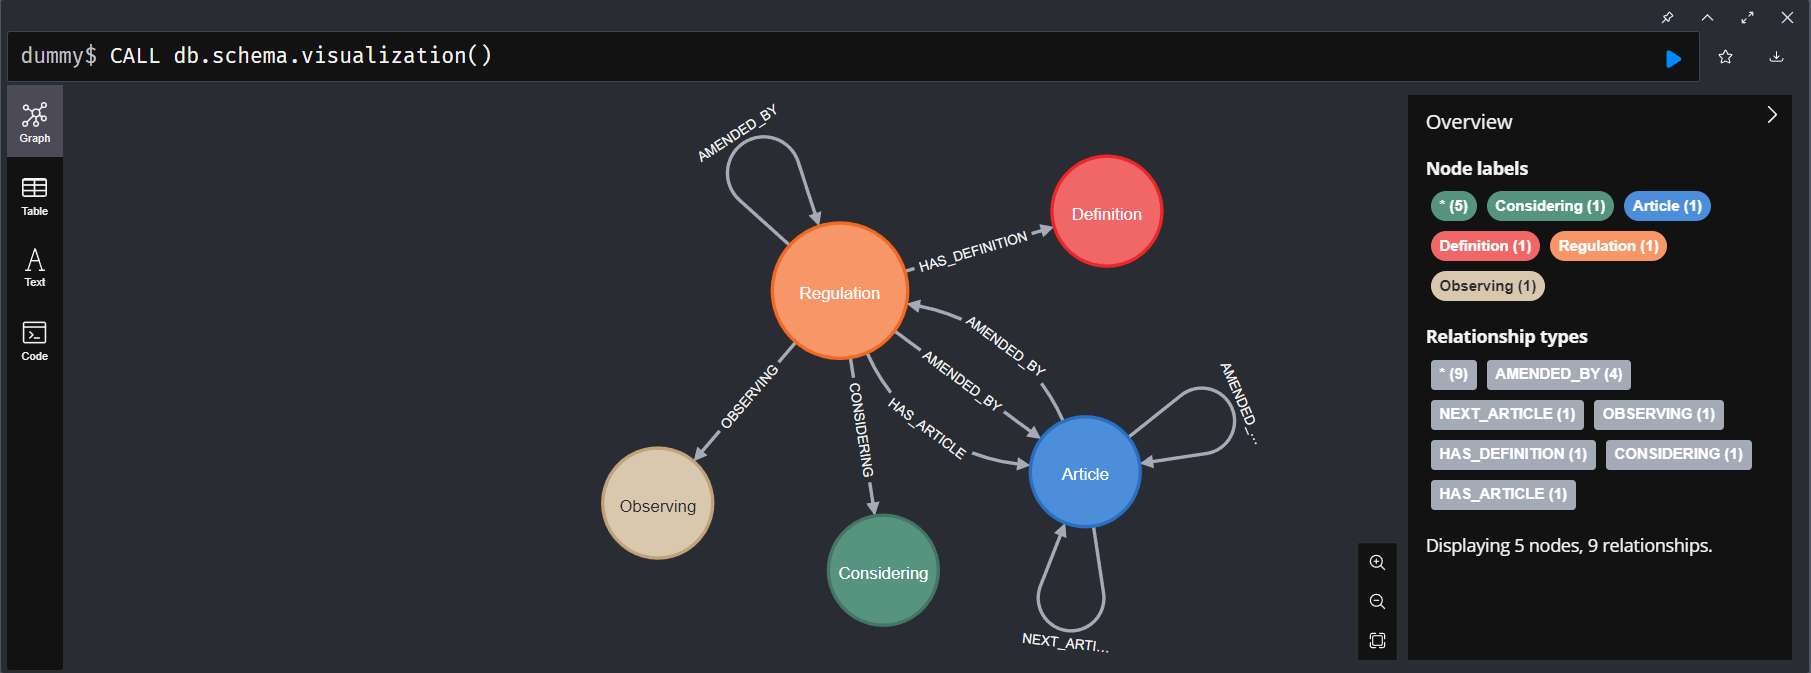
<br><br>
- **[DO]** `CALL apoc.meta.graph()`
    <br><br>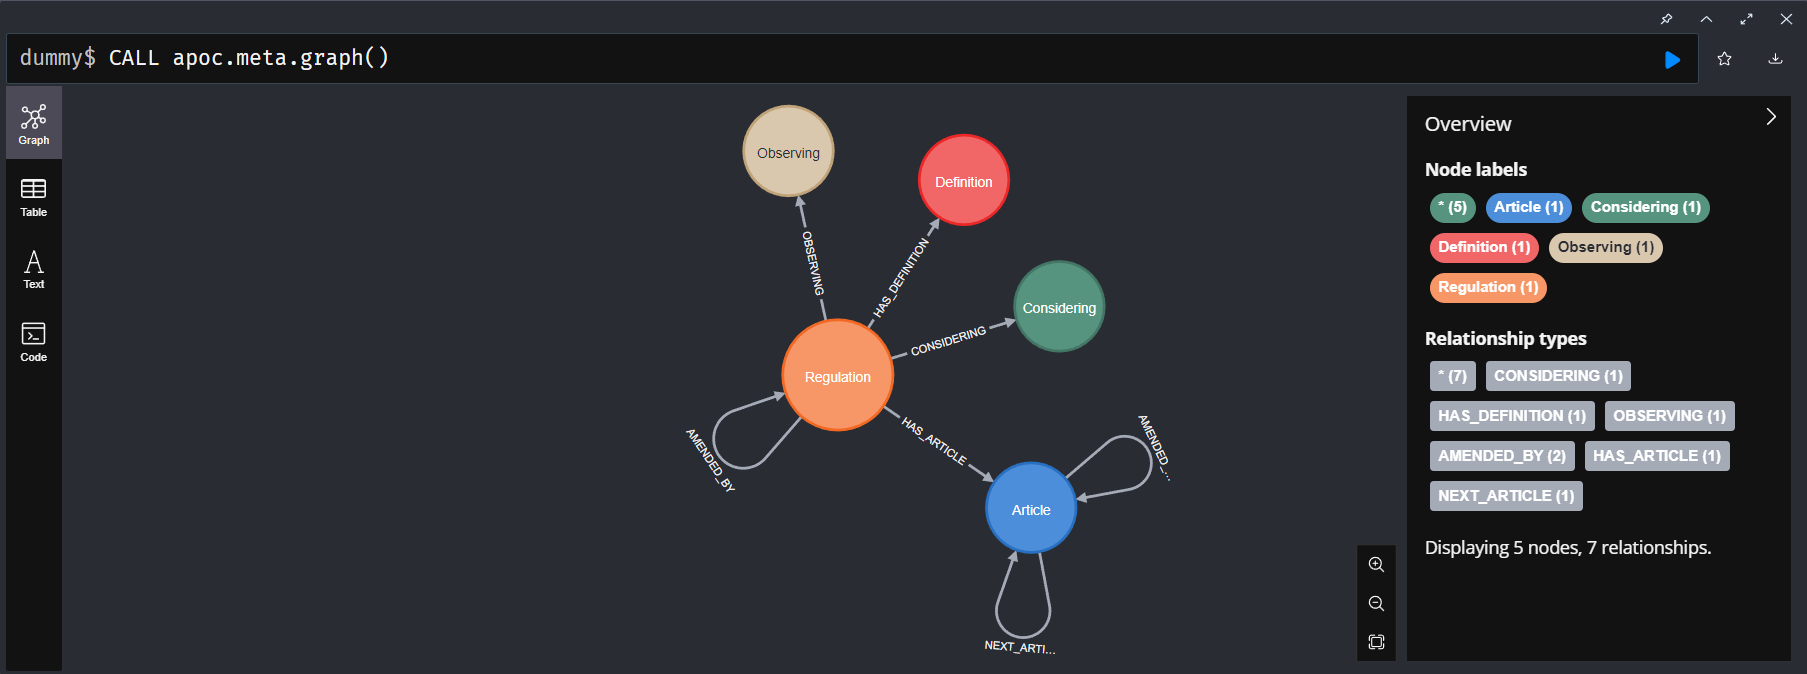

**ALASAN KENAPA `CALL db.schema.visualization()` MEMBERIKAN SCHEMA YANG TIDAK BENAR**
<br>Referensi: https://github.com/neo4j/neo4j/issues/9726#issuecomment-1466079504

> Hi! The description of db.schema.visualization has been updated to be a bit more descriptive:
> <br>
> <br>
> "Visualizes the schema of the data based on available statistics. A new node is returned for each label. The properties represented on the node include: name (label name), indexes (list of indexes), and constraints (list of constraints). A relationship of a given type is returned for all possible combinations of start and end nodes. **Note that this may include additional relationships that do not exist in the data due to the information available in the count store.**"
> <br>
> <br>
> There have also been some fixes applied to the apoc.meta.graph procedure, as the sampling was not working as expected. Allowing the sampling to now be used as intended. This should allow the sampling in the APOC procedure to be either accurate (removes all non-exisiting relationships by doing a full scan, no sampling) or using sampling, the result will be faster, but potentially less accurate.
> <br>
> <br>

**Masalah Potensial di Neo4j 1.6.1**
- Neo4j tetap running, tapi tidak dapat membuka Neo4j Desktop
    <br>Referensi: https://github.com/neo4j/neo4j/issues/13557